# Uncertainty 

This is a tutorial for the uncertainty module.

In [5]:
import copy
import scipy as sp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures, Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In [2]:
def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

def exp_func(x_exp, exp_base=exp_base):
    exp = copy.deepcopy(exp_base)
    exp.value *= x_exp
    exp.check()
    return exp

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

2021-03-04 17:22:17,687 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-04 17:22:17,735 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


## Impact 

In [3]:
exp = exp_func
exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp, exp_distr)

impf = impf_func
impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf, impf_distr)

haz = haz_base

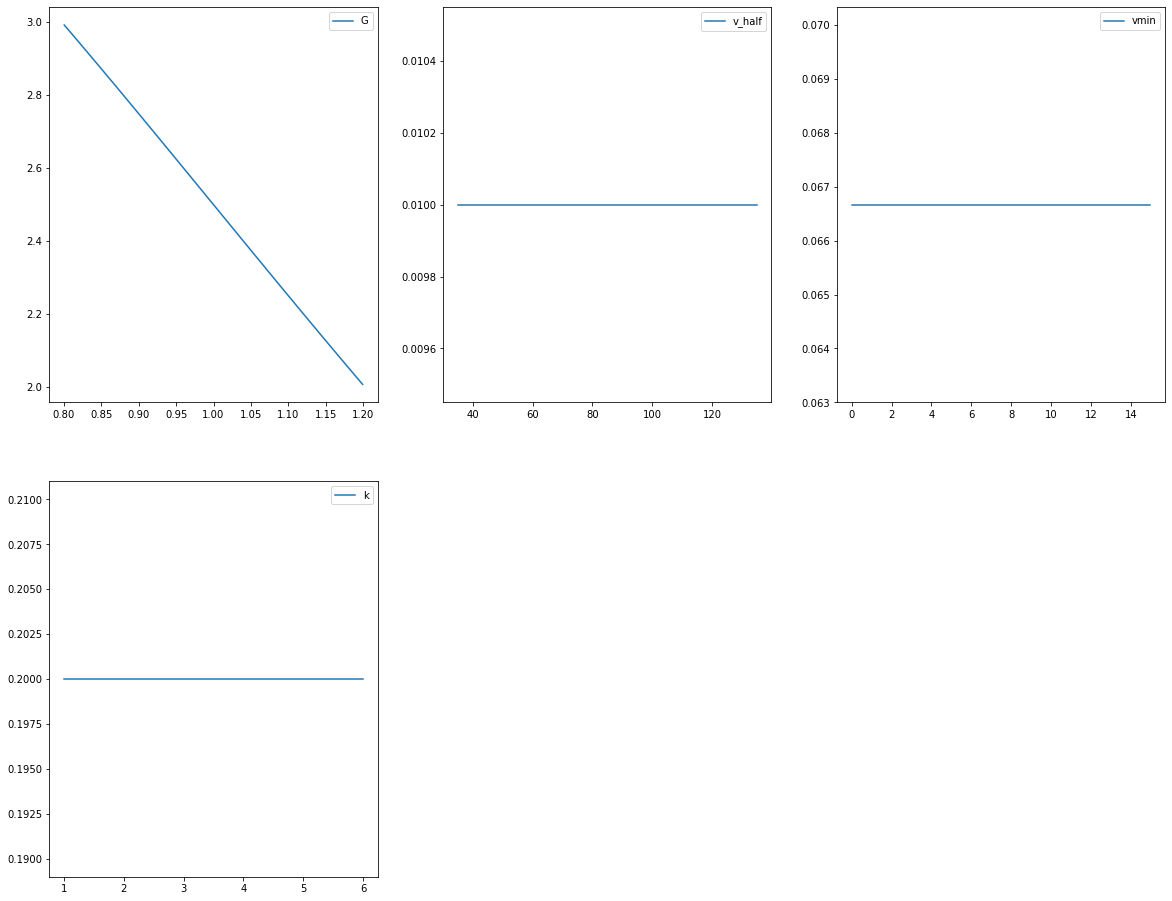

In [4]:
impf_unc.plot();

In [9]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='saltelli', sampling_kwargs = {'calc_second_order': False})

2021-03-04 16:42:13,676 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 700


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
695,0.326540,0.853179,91.494141,1.560059,5.855957
696,0.326540,1.015208,41.396484,1.560059,5.855957
697,0.326540,1.015208,91.494141,11.037598,5.855957
698,0.326540,1.015208,91.494141,1.560059,4.239746


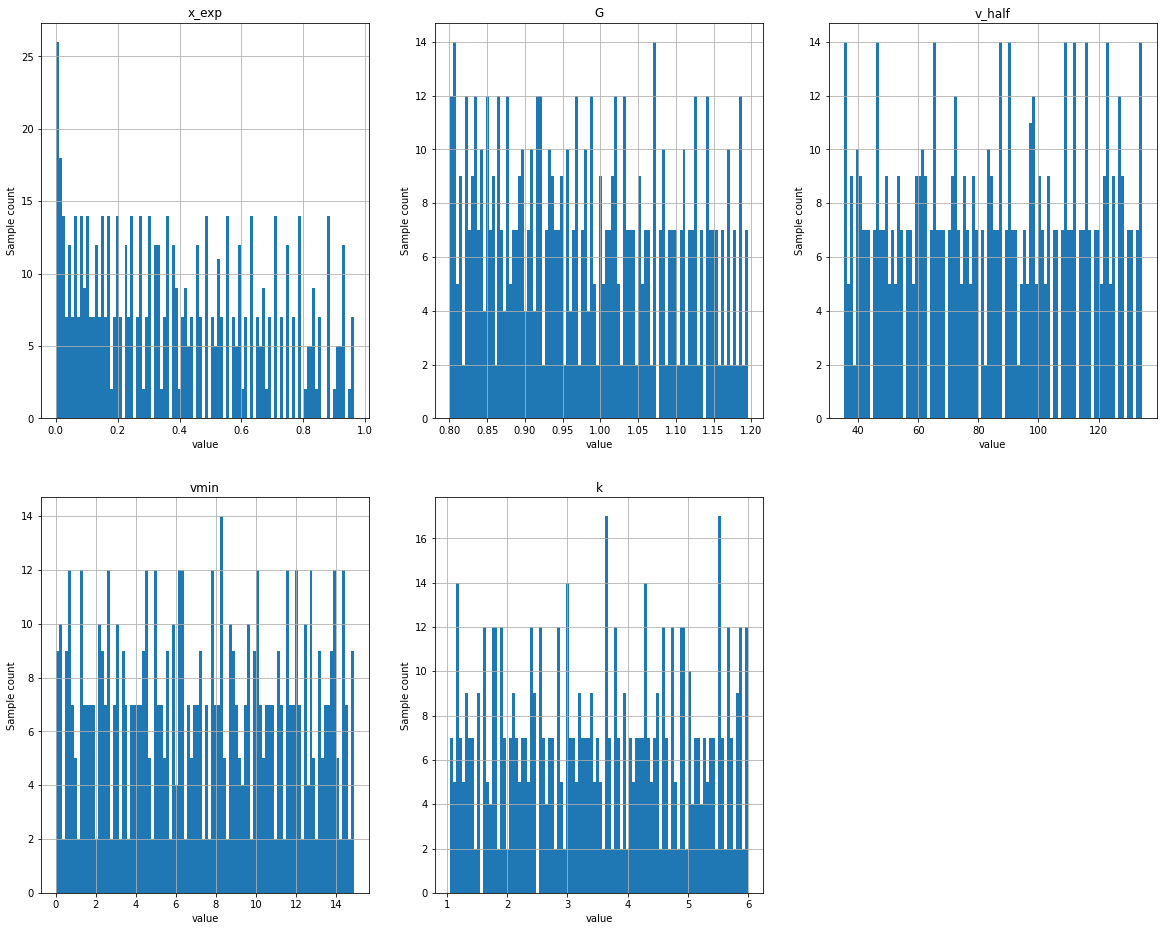

In [10]:
unc.plot_sample();

In [11]:
unc.calc_distribution(rp = [50, 100, 250])

2021-03-04 16:42:27,856 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 16:42:27,858 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-04 16:42:27,860 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 16:42:27,883 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 16:42:27,888 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 24.78s



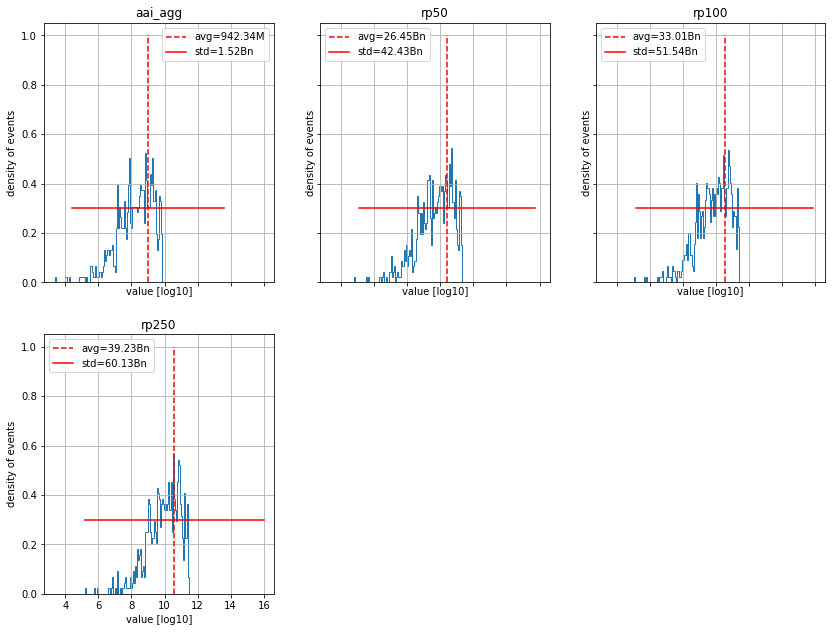

In [12]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

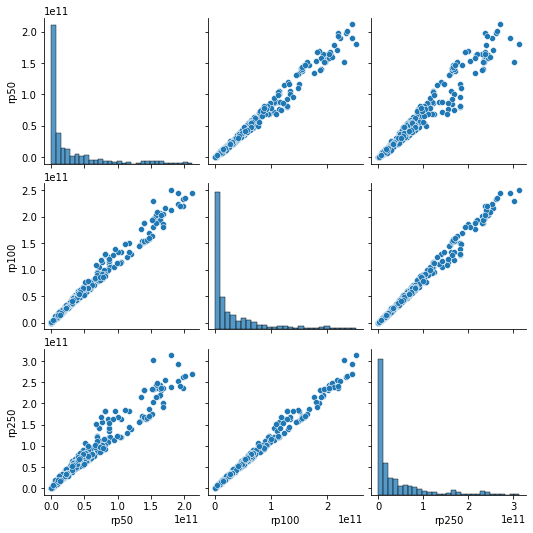

In [91]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);

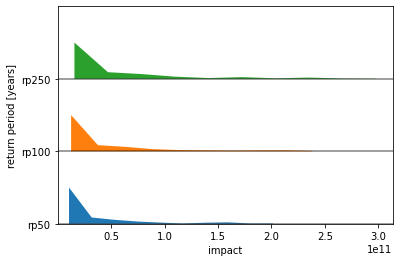

In [10]:
unc.plot_rp_distribution();

In [11]:
unc.calc_sensitivity(salib_method='sobol', method_kwargs = {'conf_level' : 0.95, 
                                                           'calc_second_order': False})

{'aai_agg': {'aai_agg': {'S1': array([0.35318387, 0.02888573, 0.29028966, 0.00244575, 0.07365607]),
   'S1_conf': array([0.15496461, 0.03978802, 0.1950814 , 0.02009894, 0.14175279]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.20277726, 0.0189451 , 0.31868244, 0.00872853, 0.13610885])}},
 'freq_curve': {'rp50': {'S1': array([0.35762565, 0.02671238, 0.30429953, 0.00039749, 0.07185341]),
   'S1_conf': array([0.17038896, 0.03997728, 0.20707335, 0.01796365, 0.11723925]),
   'ST': array([0.4598212 , 0.02464501, 0.61748473, 0.01009205, 0.23096831]),
   'ST_conf': array([0.20165425, 0.01427341, 0.33123897, 0.0060412 , 0.14823875])},
  'rp100': {'S1': array([3.68793718e-01, 2.63885339e-02, 3.39009260e-01, 2.81072504e-04,
          5.76714553e-02]),
   'S1_conf': array([0.16461108, 0.03933885, 0.24179976, 0.01635051, 0.10953629]),
   'ST': array([0.4745089 , 0.02347709, 0.71585254, 0.0063869 , 0.16279755]),
   'ST_conf': array([0.20234714

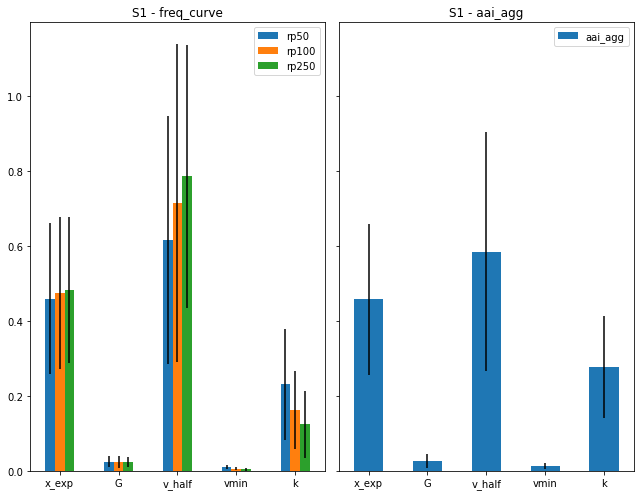

In [12]:
unc.plot_sensitivity();

## Cost Benefit 

In [13]:
def ent_today(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.value *= x_ent
    entity.check()
    return entity

def ent_future():
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040
    entity.check()
    return entity

def haz_fut_func(x_haz_fut, haz_base=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


In [14]:
haz = haz_base

haz_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_distr)

ent_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_unc = UncVar(ent_today, ent_distr)

ent_fut = ent_future()

2021-02-21 15:59:19,760 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:19,761 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:19,761 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:19,762 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:19,762 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:19,763 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:19,763 - climada.entity.exposures.base - INFO - geometry not set.


In [23]:
unc = UncCostBenefit(haz_unc=haz, ent_unc=ent_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut)
unc.make_sample(N=10)
unc.sample.head()

2021-02-21 16:00:00,548 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 60


,x_ent,x_haz_fut
0,0.919727,1.290039
1,1.218555,1.290039
2,0.919727,3.030273
3,0.919727,3.030273
4,1.218555,1.290039


In [16]:
pool = Pool()
unc.calc_distribution(pool=pool)
pool.close()
pool.join()
pool.clear()

2021-02-21 15:59:19,963 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:19,965 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:19,965 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:19,965 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:19,966 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:19,966 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:19,967 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:19,972 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:19,977 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:19,982 - climada.engine.impact - INFO - Exposures matching centroids found in centr

2021-02-21 15:59:20,367 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:20,370 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,372 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,373 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,375 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,377 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,379 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,384 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,390 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15

2021-02-21 15:59:20,504 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,505 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,508 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,514 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,513 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,517 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,522 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,523 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,523 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:

2021-02-21 15:59:20,621 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,620 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,623 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,624 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,628 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,628 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,632 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,633 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,636 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:20,64

2021-02-21 15:59:20,749 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,750 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,753 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,753 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,753 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,760 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:20,769 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:20,758 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:20,776 - cli

2021-02-21 15:59:21,003 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,004 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,013 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:21,015 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:21,016 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,019 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,020 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:21,022 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:21,023 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,031 - clima

2021-02-21 15:59:21,150 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:21,152 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,152 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:21,130 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:21,156 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:21,158 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,159 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:21,159 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:21,163 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-02-21 15:59:21,165 - climada.entity.exposures.base - INFO - regio

2021-02-21 15:59:21,273 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
Net Present Values2021-02-21 15:59:21,275 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-02-21 15:59:21,275 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:21,278 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:21,281 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:21,282 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,283 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:21,285 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,287 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:21,291 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 20

Building code              9.2              4.48068         0.487031

--------------------  --------  --------
Total climate risk:   17.9227   (USD bn)
Average annual risk:   2.02123  (USD bn)
Residual risk:         2.07937  (USD bn)
--------------------  --------  --------
2021-02-21 15:59:21,432 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Net Present Values
2021-02-21 15:59:21,437 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,443 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177          14.6519         11.1696
Beach nourishment          1.728            11.5962          6.71079
Seawall                    8.87878           0.0633377       0.0071336
Building code              9.

2021-02-21 15:59:21,699 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:21,699 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,699 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,702 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,702 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,706 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,705 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:21,707 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,709 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,709 - climada.engine.impact - INFO - Cal

2021-02-21 15:59:21,829 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,830 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,833 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,835 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,838 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,840 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,817 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:21,756 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,843 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21

2021-02-21 15:59:21,932 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,934 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,935 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-02-21 15:59:21,939 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,942 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,942 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,945 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:21,950 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,952 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:21,954 - climada.e

Building code              9.2              15.119          1.643372021-02-21 15:59:22,094 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-02-21 15:59:22,098 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

--------------------  --------  --------
Total climate risk:   60.476    (USD bn)
Average annual risk:   6.94422  (USD bn)
Residual risk:        22.8324   (USD bn)
--------------------  --------  --------
2021-02-21 15:59:22,105 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Net Present Values
2021-02-21 15:59:22,108 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,114 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves              

2021-02-21 15:59:22,346 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,346 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,349 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,350 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,349 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,352 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,355 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,355 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,358 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,359 - cli

2021-02-21 15:59:22,514 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:22,514 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,517 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,517 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:22,521 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:22,520 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,506 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,521 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:22,523 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:22,524 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,527 - climada.engin

2021-02-21 15:59:22,633 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,634 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:22,634 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:22,636 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,638 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,631 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:22,631 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-02-21 15:59:22,643 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177             6.62297        5.04889
Beach nourishment          1.728               5.20803        3.01391
Seawall                    8.87878             3.60281        0.405778
Building code              9.2                48.0945         5.22766

--------------------  -------  --------
Total climate risk:   192.378  (USD bn)
Average annual risk:   22.268  (USD bn)
Residual risk:        128.85   (USD bn)
--------------------  -------  --------
Net Present Values
2021-02-21 15:59:22,980 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:22,996 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:22,997 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no

2021-02-21 15:59:23,118 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,121 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,122 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,123 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,123 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,126 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,128 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,130 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,130 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,139 - climada.en

Building code              9.2               7.73749        0.8410312021-02-21 15:59:23,240 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-02-21 15:59:23,242 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:23,242 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-02-21 15:59:23,237 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:23,244 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

--------------------  --------  --------
Total climate risk:   30.95     (USD bn)
Average annual risk:   3.48553  (USD bn)
Residual risk:         3.6957   (USD bn)
--------------------  --------  --------
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177     

2021-02-21 15:59:23,364 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:23,366 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,370 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,372 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,372 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:23,372 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,376 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,377 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,377 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,380 - climada.engine.impact - INFO - Cal

2021-02-21 15:59:23,650 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:23,651 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:23,654 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:23,654 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-21 15:59:23,655 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:23,658 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:23,657 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:23,657 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:23,660 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:23,661 - climada.entity.exposures.base - 

2021-02-21 15:59:23,808 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,810 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,812 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,815 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,815 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,820 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,820 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,823 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,825 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,829 - cli

2021-02-21 15:59:23,979 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,973 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:23,981 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,982 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,983 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,985 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:23,982 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,989 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,990 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:23,993 - climada.engine.impact - INFO - Calc

--------------------  ---------  --------
Total climate risk:    3.91775   (USD bn)
Average annual risk:   0.35763   (USD bn)
Residual risk:        -0.167382  (USD bn)
--------------------  ---------  --------2021-02-21 15:59:24,119 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-02-21 15:59:24,120 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,121 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Net Present Values2021-02-21 15:59:24,122 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,123 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-02-21 15:59:24,126 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,129 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,13

2021-02-21 15:59:24,508 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:24,510 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:24,511 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-02-21 15:59:24,514 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:24,513 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-02-21 15:59:24,514 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:24,517 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:24,521 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:24,523 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,524 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:24,527 - climada.entity.exposures.base - INFO 

2021-02-21 15:59:24,646 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,650 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,650 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,650 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,654 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,654 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,659 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,658 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:24,664 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,664 - cli

2021-02-21 15:59:24,774 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:24,780 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

--------------------  --------  --------
Total climate risk:   114.445   (USD bn)
Average annual risk:   13.2503  (USD bn)
Residual risk:         60.7385  (USD bn)
--------------------  --------  --------
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177           7.17439        5.46925
Beach nourishment          1.728             5.77212        3.34035
Seawall                    8.87878           0.0119838      0.00134971
Building code              9.2               5.24942        0.570589



--------------------  --------  --------
Total climate risk:   20.9977   (USD bn)
Average annual risk:   2.37505  (USD bn)
Residual risk:         2.78976  (US

2021-02-21 15:59:25,111 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:25,113 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-21 15:59:25,113 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,120 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:25,116 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:25,116 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-21 15:59:25,124 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,131 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-21 15:59:25,133 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:25,134 - climada.entity.exposures.base - INFO - geometry not set.
2021-02-21 15:59:25,137 - climada.engine.impact - INFO - Calculating 

2021-02-21 15:59:25,254 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:25,256 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-21 15:59:25,259 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,265 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-02-21 15:59:25,267 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,267 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-02-21 15:59:25,269 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}

2021-02-21 15:59:25,274 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  --

Building code              9.2               28.6112         3.109912021-02-21 15:59:25,395 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,396 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


2021-02-21 15:59:25,400 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,402 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
--------------------  --------  --------
Total climate risk:   114.445   (USD bn)
Average annual risk:   13.2503  (USD bn)
Residual risk:         60.7385  (USD bn)
--------------------  --------  --------2021-02-21 15:59:25,405 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

Net Present Values2021-02-21 15:59:25,409 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-02-21 15:59:25,409 - climada.engine.impact - INFO - Expos

In [17]:
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

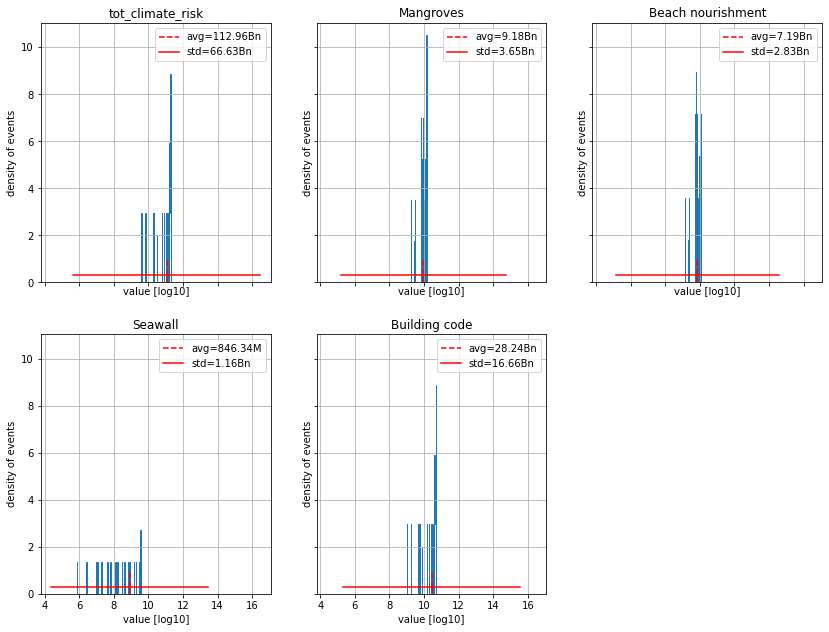

In [18]:
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

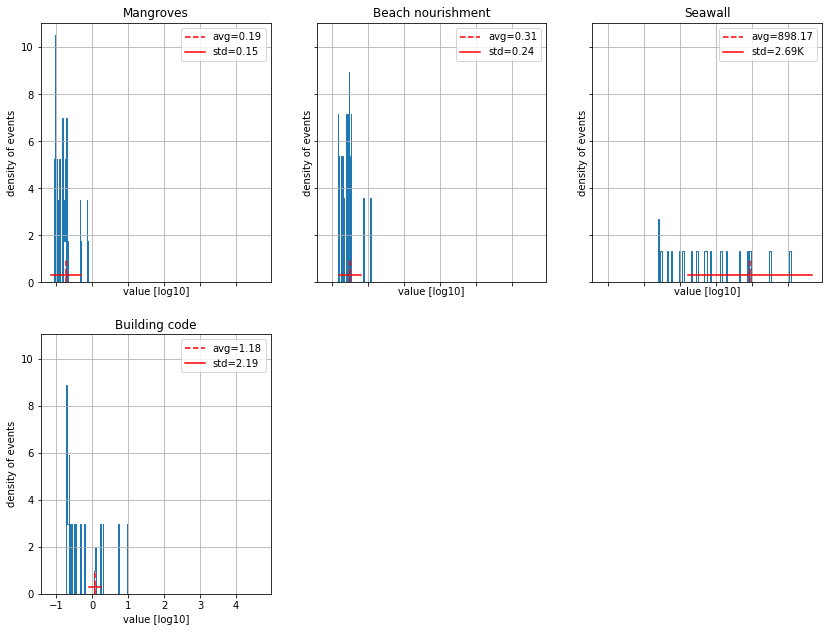

In [19]:
unc.plot_distribution(metric_list=['cost_ben_ratio'], );

In [21]:
unc.calc_sensitivity();

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

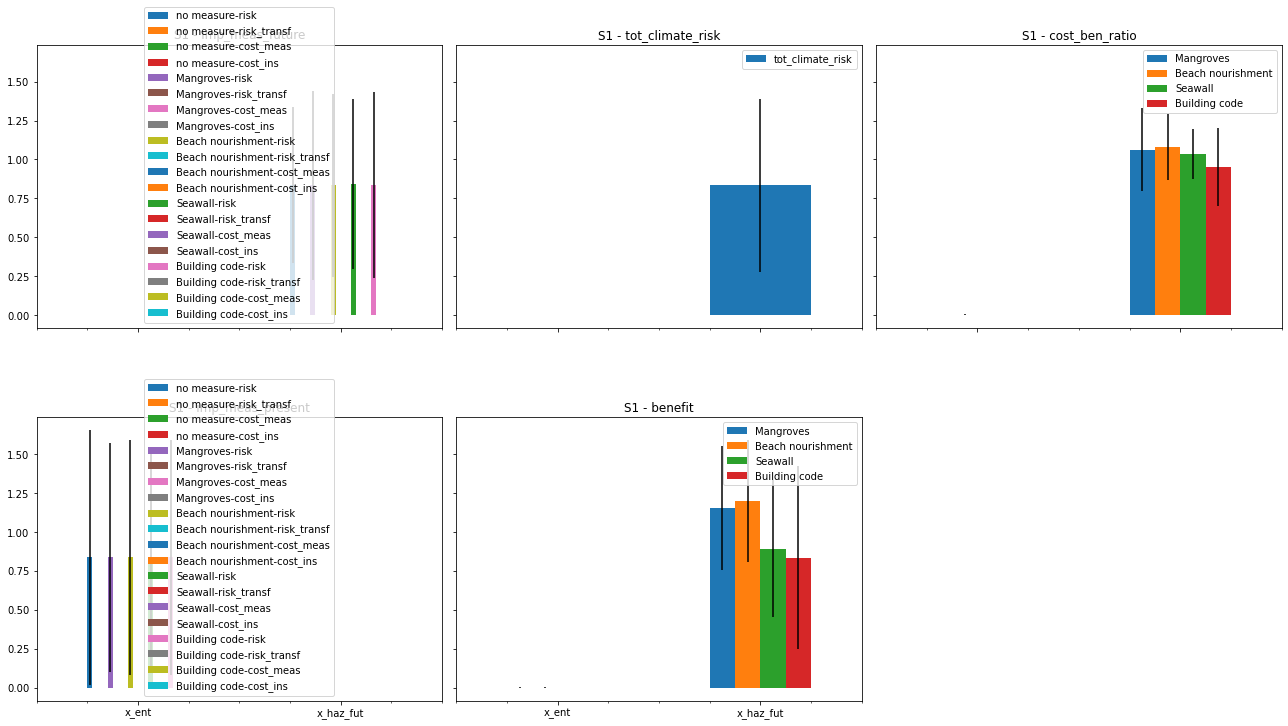

In [22]:
unc.plot_sensitivity();